### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

### Model-2

Used the same model as above but for 'input_seq_total_text_data' given only some words in the sentance not all the words. Filtered the words as below. 

<pre>
1. Training the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Removed the low idf value and high idf value words from our data. Did some analysis on the Idf values and based on those values choosed the low and high threshold value. Because very frequent words and very very rare words don't give much information. (i had plotted a box plots and taken only the idf scores within IQR range and corresponding words)<br>
4. Training the LSTM after removing the Low and High idf value words. (In model-1 Trained on total data but in Model-2 trained on data after removing some words based on IDF values)
</pre>

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png

In [1]:
import pandas as pd
import numpy as np
import keras 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,Reshape,SpatialDropout1D
from keras import Model,Input
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.regularizers import L1L2
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

Using TensorFlow backend.


## Google Colab Stuff

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
link = 'https://drive.google.com/open?id=10nvn3wpB-lwwj7dT5BhAgFjwZXw5pS5D'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_complete.csv')  
df= pd.read_csv('preprocessed_complete.csv')

## Preprocessing

In [6]:
df.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,std_price,nrm_price,presence_of_the_numerical_digits
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23,-0.390533,0.015397,0
1,1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.0,1,0.002396,0.029839,0


In [7]:
df.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'essay', 'price', 'quantity', 'std_price', 'nrm_price',
       'presence_of_the_numerical_digits'],
      dtype='object')

In [8]:
df.shape

(109248, 23)

In [9]:
df.drop(['Unnamed: 0'],axis = 1,inplace = True)
df.head(2)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,std_price,nrm_price,presence_of_the_numerical_digits
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23,-0.390533,0.015397,0
1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.0,1,0.002396,0.029839,0


In [0]:
y=df['project_is_approved']

In [0]:
df['total_text']=df['project_title']+' '+df['essay']+' '+df['project_resource_summary']

In [0]:
df=df[['total_text','school_state','project_grade_category','project_subject_categories','project_subject_subcategories','teacher_prefix','teacher_number_of_previously_posted_projects','presence_of_the_numerical_digits','price','quantity']]

In [13]:
df.head(2)

,total_text,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_prefix,teacher_number_of_previously_posted_projects,presence_of_the_numerical_digits,price,quantity
0,Educational Support for English Learners at Ho...,in,grades_prek_2,literacy_language,esl_literacy,mrs,0,0,154.6,23
1,Wanted: Projector for Hungry Learners Our stud...,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,mr,7,0,299.0,1


In [14]:
df.shape

(109248, 10)

In [15]:
y.shape

(109248,)

In [0]:
X_train,X_test,y_train,y_test=train_test_split(df,y,stratify = y, test_size = 0.3)
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,stratify = y_train, test_size = 0.2)

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_cv=to_categorical(y_cv)

In [17]:
X_train.head(2)

,total_text,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_prefix,teacher_number_of_previously_posted_projects,presence_of_the_numerical_digits,price,quantity
19499,Earbuds For Testing At my we have approximatel...,sc,grades_9_12,specialneeds,specialneeds,mrs,5,0,49.99,6
20178,"Parachutes Needed to Actively Engage! \""Have F...",ca,grades_prek_2,health_sports,gym_fitness_teamsports,mrs,1,0,115.98,2


In [18]:
X_train.shape

(61178, 10)

## Total_text_feature

In [0]:
total_text=X_train.total_text.values

In [0]:
t = Tokenizer()
t.fit_on_texts(total_text)

In [0]:
len_input1 = len(t.word_index) + 1

In [22]:
len_input1


57596

In [0]:
# Converting Textual Data to Numerical form so we can use this in Embedding Layer
encoded_docs_train = t.texts_to_sequences(total_text)
encoded_docs_train=np.array(encoded_docs_train)
encoded_docs_train=pad_sequences(encoded_docs_train, maxlen=300, padding='post')

In [0]:
encoded_docs_cv = t.texts_to_sequences(X_cv.total_text)
encoded_docs_cv=np.array(encoded_docs_cv)
encoded_docs_cv=pad_sequences(encoded_docs_cv, maxlen=300, padding='post')

In [0]:
encoded_docs_test = t.texts_to_sequences(X_test.total_text)
encoded_docs_test=np.array(encoded_docs_test)
encoded_docs_test=pad_sequences(encoded_docs_test, maxlen=300, padding='post')

In [26]:
encoded_docs_train.shape

(61178, 300)

In [27]:
encoded_docs_cv.shape

(15295, 300)

In [28]:
encoded_docs_test.shape

(32775, 300)

In [0]:
link = 'https://drive.google.com/open?id=1jyOxxCTqzM-eKXUc8qxGTZPgqkd-zUKC'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove_vectors')  

In [0]:
# Using Pretrained Glove Embedding Model
import pickle
glove = open('glove_vectors', 'rb')      
glove = pickle.load(glove)

In [31]:
type(glove)

dict

In [0]:
embedding_matrix = np.zeros((len_input1, 300))
for word, i in t.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(57596, 300)

## School State Feature

In [0]:
school_state_train=X_train.school_state.values

In [0]:
t = Tokenizer()
t.fit_on_texts(school_state_train)

In [0]:
len_input2 = len(t.word_index) + 1

In [38]:
len_input2

52

In [0]:
encoded_school_state_train = t.texts_to_sequences(school_state_train)
encoded_school_state_train=np.array(encoded_school_state_train)
encoded_school_state_train=pad_sequences(encoded_school_state_train, maxlen=1, padding='post')

In [0]:
encoded_school_state_cv = t.texts_to_sequences(X_cv.school_state)
encoded_school_state_cv=np.array(encoded_school_state_cv)
encoded_school_state_cv=pad_sequences(encoded_school_state_cv, maxlen=1, padding='post')

In [0]:
encoded_school_state_test = t.texts_to_sequences(X_test.school_state)
encoded_school_state_test=np.array(encoded_school_state_test)
encoded_school_state_test=pad_sequences(encoded_school_state_test, maxlen=1, padding='post')

## Project Grade Category Feature

In [0]:
school_PGC_train=X_train.project_grade_category.values

In [43]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(school_PGC_train)
len_input3 = len(t.word_index) + 1
print(len_input3)

5


In [0]:
encoded_PGC_train = t.texts_to_sequences(school_PGC_train)
encoded_PGC_train=np.array(encoded_PGC_train)
encoded_PGC_train=pad_sequences(encoded_PGC_train, maxlen=1, padding='post')

In [0]:
encoded_PGC_cv = t.texts_to_sequences(X_cv.project_grade_category)
encoded_PGC_cv=np.array(encoded_PGC_cv)
encoded_PGC_cv=pad_sequences(encoded_PGC_cv, maxlen=1, padding='post')

In [0]:
encoded_PGC_test = t.texts_to_sequences(X_test.project_grade_category)
encoded_PGC_test=np.array(encoded_PGC_test)
encoded_PGC_test=pad_sequences(encoded_PGC_test, maxlen=1, padding='post')

## Project Subject Category Feature

In [0]:
school_PSC_train=X_train.project_subject_categories.values

In [48]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(school_PSC_train)
len_input4 = len(t.word_index) + 1
print(len_input4)

51


In [0]:
encoded_PSC_train = t.texts_to_sequences(school_PSC_train)
encoded_PSC_train=np.array(encoded_PSC_train)
encoded_PSC_train=pad_sequences(encoded_PSC_train, maxlen=1, padding='post')

In [0]:
encoded_PSC_cv = t.texts_to_sequences(X_cv.project_subject_categories)
encoded_PSC_cv=np.array(encoded_PSC_cv)
encoded_PSC_cv=pad_sequences(encoded_PSC_cv, maxlen=1, padding='post')

In [0]:
encoded_PSC_test = t.texts_to_sequences(X_test.project_subject_categories)
encoded_PSC_test=np.array(encoded_PSC_test)
encoded_PSC_test=pad_sequences(encoded_PSC_test, maxlen=1, padding='post')

## Project Subject SubCategory Feature

In [0]:
school_PSSC_train=X_train.project_subject_subcategories.values

In [53]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(school_PSSC_train)
len_input5 = len(t.word_index) + 1
print(len_input5)

383


In [0]:
encoded_PSSC_train = t.texts_to_sequences(school_PSSC_train)
encoded_PSSC_train=np.array(encoded_PSSC_train)
encoded_PSSC_train=pad_sequences(encoded_PSSC_train, maxlen=1, padding='post')

In [0]:
encoded_PSSC_cv = t.texts_to_sequences(X_cv.project_subject_subcategories)
encoded_PSSC_cv=np.array(encoded_PSSC_cv)
encoded_PSSC_cv=pad_sequences(encoded_PSSC_cv, maxlen=1, padding='post')

In [0]:
encoded_PSSC_test = t.texts_to_sequences(X_test.project_subject_subcategories)
encoded_PSSC_test=np.array(encoded_PSSC_test)
encoded_PSSC_test=pad_sequences(encoded_PSSC_test, maxlen=1, padding='post')

## Teacher_prefix Feature

In [0]:
teacher_prefix_train=X_train.teacher_prefix.values

In [58]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(teacher_prefix_train)
len_input6 = len(t.word_index) + 1
print(len_input6)

6


In [0]:
encoded_teacher_pre_train = t.texts_to_sequences(teacher_prefix_train)
encoded_teacher_pre_train=np.array(encoded_teacher_pre_train)
encoded_teacher_pre_train=pad_sequences(encoded_teacher_pre_train, maxlen=1, padding='post')

In [0]:
encoded_teacher_pre_cv = t.texts_to_sequences(X_cv.teacher_prefix)
encoded_teacher_pre_cv=np.array(encoded_teacher_pre_cv)
encoded_teacher_pre_cv=pad_sequences(encoded_teacher_pre_cv, maxlen=1, padding='post')

In [0]:
encoded_teacher_pre_test = t.texts_to_sequences(X_test.teacher_prefix)
encoded_teacher_pre_test=np.array(encoded_teacher_pre_test)
encoded_teacher_pre_test=pad_sequences(encoded_teacher_pre_test, maxlen=1, padding='post')

## Numerical Features

In [0]:
X_train_numeric=[]
for i in range(X_train.shape[0]):
    vec=[]
    vec.append(X_train.iloc[i,6])
    vec.append(X_train.iloc[i,7])
    vec.append(X_train.iloc[i,8])
    vec.append(X_train.iloc[i,9])
    X_train_numeric.append(vec)
X_train_numeric=np.array(X_train_numeric)    

In [0]:
X_cv_numeric=[]
for i in range(X_cv.shape[0]):
    vec=[]
    vec.append(X_cv.iloc[i,6])
    vec.append(X_cv.iloc[i,7])
    vec.append(X_cv.iloc[i,8])
    vec.append(X_cv.iloc[i,9])
    X_cv_numeric.append(vec)
    
X_cv_numeric=np.array(X_cv_numeric)

In [0]:
X_test_numeric=[]
for i in range(X_test.shape[0]):
    vec=[]
    vec.append(X_test.iloc[i,6])
    vec.append(X_test.iloc[i,7])
    vec.append(X_test.iloc[i,8])
    vec.append(X_test.iloc[i,9])
    X_test_numeric.append(vec)
X_test_numeric=np.array(X_test_numeric)

## Model

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true,y_pred):
    return tf.py_func(roc_auc_score,(y_true,y_pred),tf.double)

In [75]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://8ce3ed56.ngrok.io


In [76]:
from keras.callbacks import TensorBoard

input1=Input(shape=(300,))
x1=Embedding(input_dim=len_input1, output_dim=300, weights=[embedding_matrix], trainable=False)(input1)
x1=SpatialDropout1D(0.3)(x1)
x1=LSTM(128,return_sequences=True)(x1)
x1=Flatten()(x1)

input2=Input(shape=(1,))
x2=Embedding(input_dim= len_input2,output_dim= 2)(input2)
x2=Flatten()(x2)

input3=Input(shape=(1,))
x3=Embedding(input_dim= len_input3,output_dim= 2)(input3)
x3= Flatten()(x3)

input4=Input(shape=(1,))
x4=Embedding(input_dim=len_input4,output_dim= 2)(input4)
x4=Flatten()(x4)

input5=Input(shape=(1,))
x5=Embedding(input_dim=len_input5,output_dim= 50)(input5)
x5=Flatten()(x5)

input6=Input(shape=(1,))
x6=Embedding(input_dim=len_input6,output_dim= 5)(input6)
x6=Flatten()(x6)

input7=Input(shape=(4,))
x7=Dense(16,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(input7)

concat=concatenate([x1,x2,x3,x4,x5,x6,x7])

x=Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(concat)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(x)
x=Dropout(0.5)(x)
x=BatchNormalization()(x)
x=Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(x)
x=Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)


model=Model([input1,input2,input3,input4,input5,input6,input7], output)


tensorboard=TensorBoard(log_dir="logs")

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=[auroc])

print(model.summary())



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 300, 300)     17278800    input_15[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 300, 300)     0           embedding_13[0][0]               
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

In [77]:
#keras.backend.get_session().run(tf.global_variables_initializer())
model.fit([encoded_docs_train,encoded_school_state_train,encoded_PGC_train,encoded_PSC_train,encoded_PSSC_train,
           encoded_teacher_pre_train,X_train_numeric], y_train, epochs=18,verbose=1,batch_size=256,class_weight='balanced',
          validation_data=([encoded_docs_cv,encoded_school_state_cv,encoded_PGC_cv,encoded_PSC_cv,encoded_PSSC_cv,
           encoded_teacher_pre_cv,X_cv_numeric],y_cv),callbacks=[TensorBoardColabCallback(tbc)] )

Train on 61178 samples, validate on 15295 samples
Epoch 1/18
61178/61178 [==============================] - 151s 2ms/step - loss: 0.7614 - auroc: 0.5085 - val_loss: 0.4711 - val_auroc: 0.5937
Epoch 2/18
61178/61178 [==============================] - 149s 2ms/step - loss: 0.5163 - auroc: 0.5259 - val_loss: 0.4628 - val_auroc: 0.5961
Epoch 3/18
61178/61178 [==============================] - 150s 2ms/step - loss: 0.4716 - auroc: 0.5466 - val_loss: 0.4486 - val_auroc: 0.6038
Epoch 4/18
61178/61178 [==============================] - 149s 2ms/step - loss: 0.4550 - auroc: 0.5561 - val_loss: 0.4438 - val_auroc: 0.6090
Epoch 5/18
61178/61178 [==============================] - 150s 2ms/step - loss: 0.4396 - auroc: 0.5989 - val_loss: 0.4143 - val_auroc: 0.7033
Epoch 6/18
61178/61178 [==============================] - 149s 2ms/step - loss: 0.4212 - auroc: 0.6724 - val_loss: 0.3992 - val_auroc: 0.7314
Epoch 7/18
61178/61178 [==============================] - 149s 2ms/step - loss: 0.4089 - auroc: 0.

In [0]:
pred=model.predict([encoded_docs_test,encoded_school_state_test,encoded_PGC_test,encoded_PSC_test,encoded_PSSC_test,
           encoded_teacher_pre_test,X_test_numeric])

In [79]:
roc_auc_score(y_test,pred)

0.7767883423193852

### Loss with Epochs [Training:Orange, Validation:Blue]

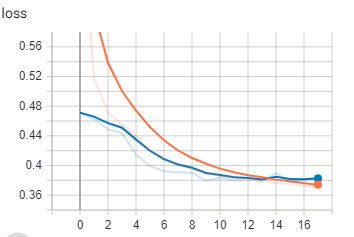

In [1]:
from IPython.display import Image
Image(filename='model1_loss.png')

#### As we can see training and validation loss are very close so there is no overfitting and our model is fine

### AUC with Epochs[Training:Orange, Validation:Blue]

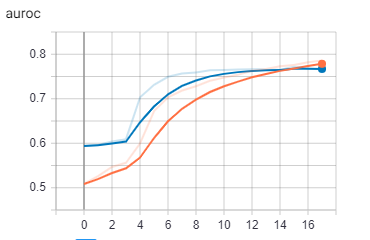

In [2]:
from IPython.display import Image
Image(filename='model1_auc.png')

# Conclusion

* In this model we created seven inputs, First Input will take the total Textual features like project title, Essay, Project Resource Summary and 2,3,4,5,6 inputs are categorical features and the sevents input will contain all the numirical data like price quantity etc
* First Input will be passed to a LSTM Layer 
* Seventh input will be passed to a densu relu activated layer
* And all other inputs are passed to embedding layer for trainig 
* We have used L2 regularizer to prevent our model from overfitting 
* we have used adam optimizer
* After 18 Epochs:
    Training Loss-0.3712
    Validation Loss-0.3845
    Training AUC-0.7858 
    Validation AUC-0.7663
* Testing AUC of this Model is 0.7767